In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from astropy.io import fits
from specim_test.specim.specfuncs import spec2d, spec1d
from scipy.ndimage import shift

In [3]:
file_loc = '../galaxy_spectra/LRIS_data/J0659/*'

In [12]:
spec2d_file_list = []
#var2d_file_list = []
#out_file = []
for i,p in enumerate(glob.glob(file_loc)):
    fl = int(p[-8:-6])
    if fl==41 or fl==40:
        spec2d_file_list.append(p)

In [13]:
spec2d_file_list

['../galaxy_spectra/LRIS_data/J0659/szfpr190303_0041r.fits',
 '../galaxy_spectra/LRIS_data/J0659/szfpr190303_0040r.fits']

In [14]:
spec1 = spec2d.Spec2d(spec2d_file_list[0], varext=1, ytrim=[25, 85])
spec2 = spec2d.Spec2d(spec2d_file_list[1], varext=1, ytrim=[25, 85])


Loading file ../galaxy_spectra/LRIS_data/J0659/szfpr190303_0041r.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../galaxy_spectra/LRIS_data/J0659/szfpr190303_0041r.fits (HDU=0)
The input dataset was trimmed
 xrange: 0:4096.  yrange: 25:86
Final data dimensions (x y): 4096 x 61

Dispersion axis:              x
N_pixels along dispersion axis: 4096


Loading file ../galaxy_spectra/LRIS_data/J0659/szfpr190303_0040r.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../galaxy_spectra/LRIS_data/J0659/szfpr190303_0040r.fits (HDU=0)
The input dataset was trimmed
 xrange: 0:4096.  yrange: 25:86
Final data dimensions (x y): 4096 x 61

Dispersion axis:              x
N_pixels along dispersion axis: 4096



In [15]:
for f in spec2d_file_list:
    hd = fits.open(f)[0].header
    print(hd['CD1_1'], hd['CRPIX1'], hd['CRVAL1'], hd['EXPTIME'])

0.4 2048.0 6400.40087891 179.99679565
0.4 2048.0 6400.40087891 29.99480057


Profile max value (before normalization) 8834.611328


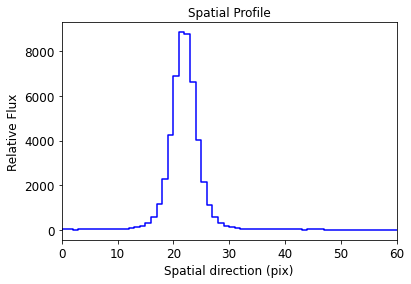


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 1

Now enter constants of the background polynomial upto degree 0
c0 : 1

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 8800, 23, 3, 4

amplitude=8800.000000, x_0=23.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Polynomial1D(0, c0=36.87306032)>

    [1]: <Moffat1D(amplitude=9088.80996459, x_0=22.45585424, gamma=4.87910302, alpha=3.40926783)>
Parameters:
           c0_0          amplitude_1    ...     gamma_1           alpha_1      
    ------------------ ---------------- ... ---------------- ------------------
    

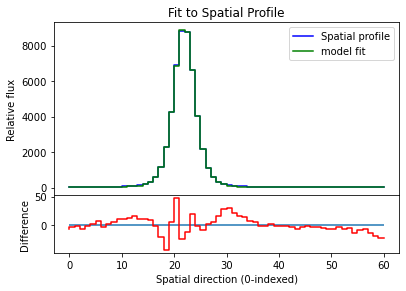

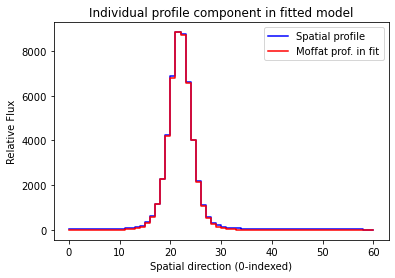


Do you want to start over ? : type yes/no
no
Profile max value (before normalization) 1621.290039


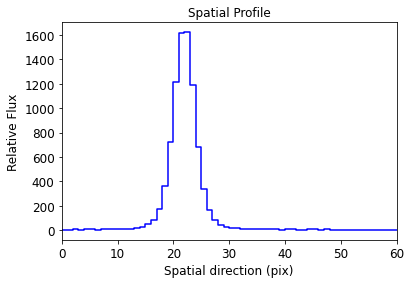


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 1

Now enter constants of the background polynomial upto degree 0
c0 : 1

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 1600, 23, 3, 4

amplitude=1600.000000, x_0=23.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Polynomial1D(0, c0=6.71599057)>

    [1]: <Moffat1D(amplitude=1680.32966192, x_0=22.46985709, gamma=4.76724339, alpha=3.64552386)>
Parameters:
           c0_0          amplitude_1     ...     gamma_1           alpha_1      
    ----------------- ------------------ ... ---------------- ------------------
   

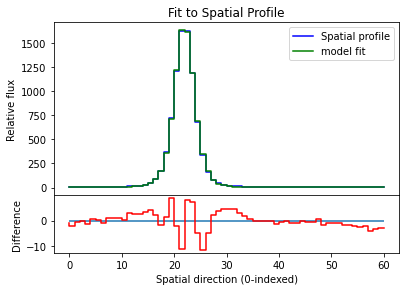

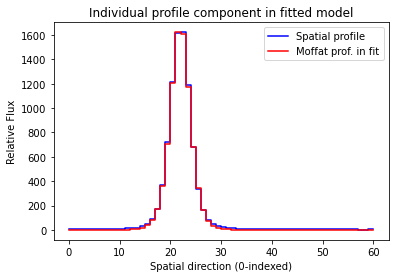


Do you want to start over ? : type yes/no
no


In [16]:
spec_list = [spec1, spec2]

for i,sp in enumerate(spec_list):
    profile = sp.spatial_profile(pixrange=[2400, 2900])
    plt.show()
    sp.initial_model()

In [17]:
for i,sp in enumerate(spec_list):
    if i==0:
        print(sp.mod0.x_0_1.value)
        cen1 = sp.mod0.x_0_1.value
    else:
        print(cen1 - sp.mod0.x_0_1.value)

22.45585423930909
-0.014002855274348747


In [18]:
shifted_sp = []
shifted_var = []
shift_pixel = np.array([0.0, -0.014])

for i, sp in enumerate(spec_list):
    #print(sp[order-1].mod0, shift[i])
    nanmask = (sp.vardata <= 0) | (np.isnan(sp.vardata)) 
    nnan = nanmask.sum()
    if nnan > 0:
        print('Found %d NaNs in the two-dimensional variance '\
              'spectrum' % nnan)

        """ Replace the NaNs with a big value """
        sp.vardata[nanmask] = 1.e5
    shifted_sp.append(shift(sp.data, [shift_pixel[i], 0], order=1))
    shifted_var.append(shift(sp.vardata, [shift_pixel[i], 0], order=1))

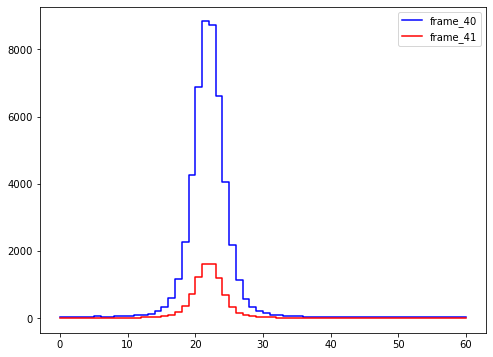

In [22]:
plt.figure(figsize=(8, 6))
color = ['b', 'r']
label = ['frame_40','frame_41']
pix_range = [[2400, 2900], [2400, 2900]]
i=0
for p, pix in zip(shifted_sp, pix_range):
    tmpdata = p[:, pix[0]:pix[1]]
    pflux = np.median(tmpdata, axis=1)
    x = np.arange(p.shape[0])
    plt.plot(x, pflux, color=color[i], drawstyle='steps', label=label[i])
    plt.legend()
    i += 1
    #plt.title('order %d' %od)

In [23]:
wtsp = np.zeros(shifted_sp[0].shape)
wtsum = np.zeros(shifted_sp[0].shape)
for s, v in zip(shifted_sp, shifted_var):
    wt = np.zeros(wtsp.shape)
    mask = np.isnan(v) | (v<=0)
    wt[~mask] = 1.0 / v[~mask]
    #print(sum(sum(np.isnan(wt) | (wt<=0))))
    wtsp += wt * s
    #print(sum(sum(wtsp==0)))
    wtsum += wt
    #print(sum(sum(wtsum==0)))

wtsp[wtsum == 0] = 0
wtsum[wtsum == 0] = 1
outsp = wtsp / wtsum
outvar = 1.0 / wtsum

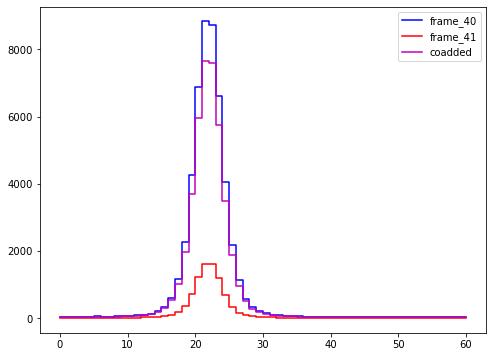

In [24]:
plt.figure(figsize=(8, 6))
color = ['b', 'r']
label = ['frame_40','frame_41']
pix_range = [[2400, 2900], [2400, 2900]]
i=0
for p, pix in zip(shifted_sp, pix_range):
    tmpdata = p[:, pix[0]:pix[1]]
    pflux = np.median(tmpdata, axis=1)
    x = np.arange(p.shape[0])
    plt.plot(x, pflux, color=color[i], drawstyle='steps', label=label[i])
    plt.legend()
    i += 1
tmpdata = outsp[:, pix[0]:pix[1]]
pflux = np.median(tmpdata, axis=1)
x = np.arange(outsp.shape[0])
plt.plot(x, pflux, color='m', drawstyle='steps', label='coadded')
plt.legend()

In [25]:
s = fits.open('../galaxy_spectra/LRIS_data/J0659/szfpr190303_0041r.fits')
file_name1 = 'J0659_LRIS_spectra/G191_star_coadd2d_sp'  + '.fits'
file_name2 = 'J0659_LRIS_spectra/G191_star_coadd2d_var' + '.fits'
fits.writeto(file_name1, outsp, header=s[0].header)
fits.writeto(file_name2, outvar, header=s[0].header)

## Now extract 1d spectrum

In [43]:
sp_file = 'J0659_LRIS_spectra/G191_star_coadd2d_sp.fits'
var_file = 'J0659_LRIS_spectra/G191_star_coadd2d_var.fits'
spec = spec2d.Spec2d(inspec=sp_file, invar=var_file)


Loading file J0659_LRIS_spectra/G191_star_coadd2d_sp.fits
-----------------------------------------------

Loading file J0659_LRIS_spectra/G191_star_coadd2d_var.fits
-----------------------------------------------
Read in 2-dimensional spectrum from J0659_LRIS_spectra/G191_star_coadd2d_sp.fits (HDU=0)
Final data dimensions (x y): 4096 x 61

Dispersion axis:              x
N_pixels along dispersion axis: 4096



Profile max value (before normalization) 7649.046111


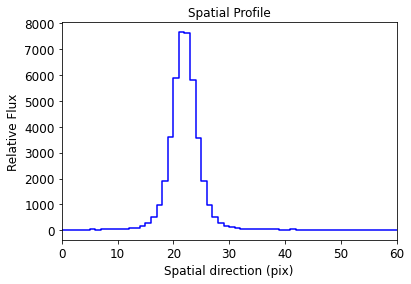


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 1

Now enter constants of the background polynomial upto degree 0
c0 : 10

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 7650, 23, 3, 4

amplitude=7650.000000, x_0=23.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Polynomial1D(0, c0=32.18738931)>

    [1]: <Moffat1D(amplitude=7885.6409114, x_0=22.48831347, gamma=4.85209518, alpha=3.39500319)>
Parameters:
           c0_0          amplitude_1    ...      gamma_1           alpha_1      
    ----------------- ----------------- ... ----------------- ------------------
  

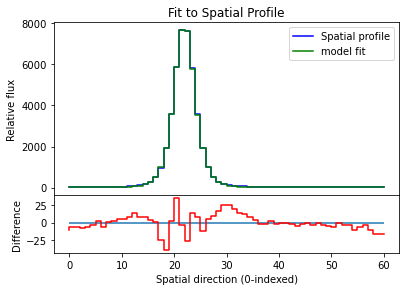

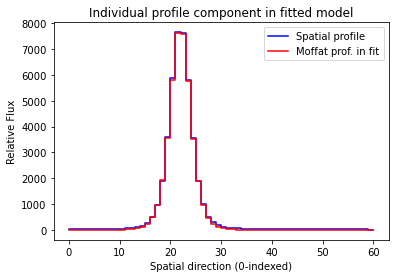


Do you want to start over ? : type yes/no
no


<CompoundModel(c0_0=32.18738931, amplitude_1=7885.6409114, x_0_1=22.48831347, gamma_1=4.85209518, alpha_1=3.39500319)>

In [44]:
spec.spatial_profile(pixrange=[2500, 3000])
plt.show()
spec.initial_model()


Running fit_trace
---------------------------------------------------------
Fitting to the trace at 163 segments
  of the 2D spectrum with stepsize=25 pix ...
    Done
Fitting polynomial of degree 3 to parameter: c0_0
Fitting polynomial of degree 4 to parameter: x_0_1
Fitting polynomial of degree 3 to parameter: gamma_1
Fitting polynomial of degree 3 to parameter: alpha_1


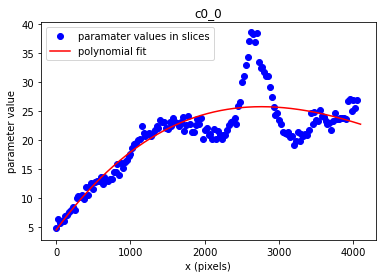

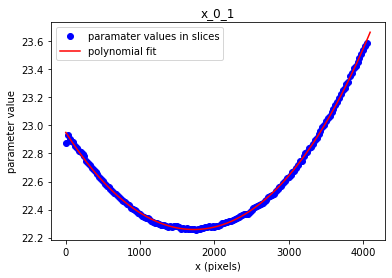

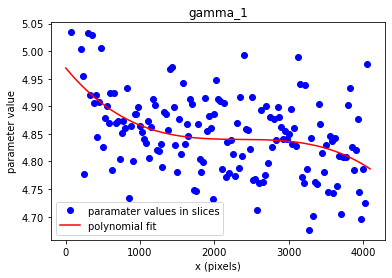

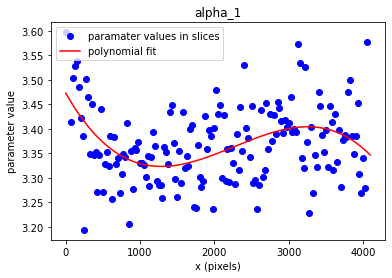

In [45]:
spec.find_and_trace(spec.mod0, stepsize=25, fitorder={'x_0_1':4, 'mean_1':4, 'x_0_2':4, 'x_0_3':4},
                    fitrange=[0, 4100], polyorder=3)
plt.show()

Fitting to 1 components, plus a background
Extracting the spectrum.  Please be patient
 Extraction range (pixels): 0 - 4096
Fitting to the trace at 4096 segments
  of the 2D spectrum with stepsize=1 pix ...
 Spectrum Start:  5581.60
 Spectrum End:     7219.60
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40


Plotting the spectrum


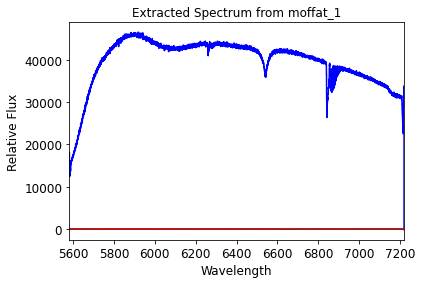

In [46]:
spec.extract(method='modelfit')
plt.show()

In [48]:
spec.spectra[0][1].save('spec1d_G191_star_lris_2019.fits', outformat='fits')

Saved spectrum to file spec1d_G191_star_lris_2019.fits in format fits


## Create the response curve now

In [49]:
obs_spec= spec1d.Spec1d('J0659_LRIS_spectra/spec1d_G191_star_lris_2019.fits', informat='fits')


Reading spectrum from J0659_LRIS_spectra/spec1d_G191_star_lris_2019.fits
Expected file format: fits
 Spectrum Start:  5581.60
 Spectrum End:     7219.60
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



In [50]:
wav_range = [[6200, 6300, 100], [6400, 6660, 130], [6750, 6950, 100], [7100, 7300, 150, 0]]

In [51]:
clst_wav_range, wav_index = obs_spec.closest_wavrange(wav_range, verbose=False)
#sp.plot_maskedreg(clst_wav_range)

bkgwidth =[]
for i, p in enumerate(wav_range):

    if len(p)==4:
        bkgwidth.append([p[2], p[3]])
    elif len(p)==3:
        bkgwidth.append(p[2])
    else:
        bkgwidth.append(50)
#print(bkgwidth)

for j, (p, r) in enumerate(zip(clst_wav_range, bkgwidth)):

    linereg = np.array([p[0], p[1]])
    #print(linereg, r)

    obs_spec.mask_line(linereg, r)

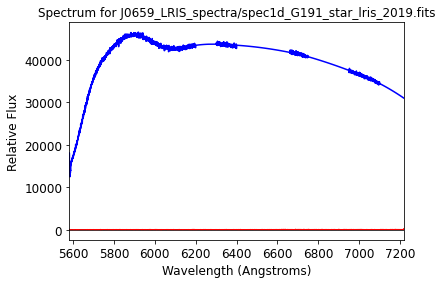

In [52]:
obs_spec.plot()

In [53]:
calb_spec = spec1d.Spec1d('../other_spectra/feige110_ir_osp.fits', informat='fitsflux')


Reading spectrum from ../other_spectra/feige110_ir_osp.fits
Expected file format: fitsflux
 Spectrum Start:  3200.00
 Spectrum End:    11200.00
 Dispersion (1st pixel):   1.00
 Dispersion (average):      1.00



In [54]:
modlines = [(3700.46, 5020, 100, 600), (6524.47, 6619.27, 10, 10)]

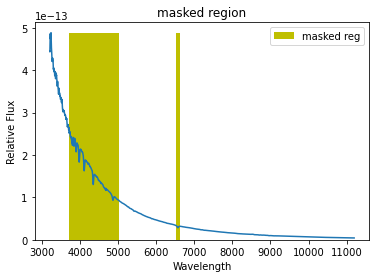

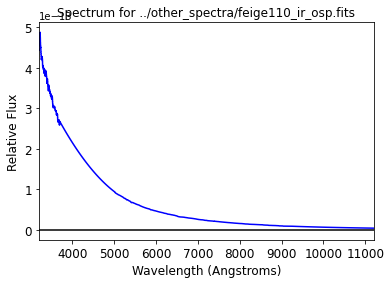

In [55]:
clst_wav_range, wav_index = calb_spec.closest_wavrange(modlines, verbose=False)
calb_spec.plot_maskedreg(clst_wav_range)

bkgwidth =[]
for i, p in enumerate(modlines):

    if len(p)==4:
        bkgwidth.append([p[2], p[3]])
    elif len(p)==3:
        bkgwidth.append(p[2])
    else:
        bkgwidth.append(100)
#print(bkgwidth)

for j, (p, r) in enumerate(zip(clst_wav_range, bkgwidth)):

    linereg = np.array([p[0], p[1]])
    #print(linereg, r)

    calb_spec.mask_line(linereg, r)
calb_spec.plot()

resample: replacing input spectrum with resampled version
resample: for now not resampling the variance


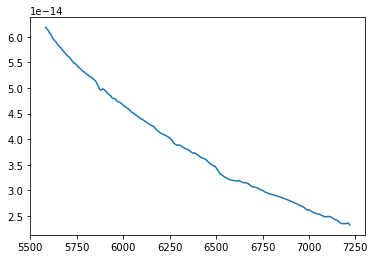

3.6950213668035166e-14

In [56]:
calb_spec.resample(owave=obs_spec['wav'])
plt.plot(calb_spec.rswav, calb_spec.rsflux)
plt.show()
norm = np.median(calb_spec.rsflux)
norm

In [57]:
response_curve = obs_spec['flux'] / (calb_spec.rsflux / norm)

Text(0.5, 1.0, 'response curve')

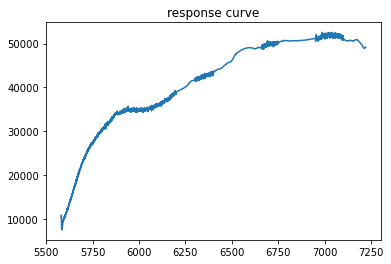

In [58]:
plt.figure()
plt.plot(obs_spec['wav'], response_curve)
plt.title('response curve')

In [59]:
response1d = spec1d.Spec1d(wav=obs_spec['wav'], flux=response_curve)

 Spectrum Start:  5581.60
 Spectrum End:     7219.60
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



In [60]:
response1d.save('J0659_LRIS_spectra/response_curve_from_G191_lris_coadd2d.txt', outformat='text')


Saved spectrum to file J0659_LRIS_spectra/response_curve_from_G191_lris_coadd2d.txt in format text
